###  Zhao, Morrison, Parr Inversion Method:

In [1]:
import os
import psi4
import matplotlib.pyplot as plt
import numpy as np
# import numpy_html
psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

#Define Psi4 geometries. Symmetries need to be set to C1. 


Ne = psi4.geometry( 
""" 
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )


#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "rhf"})

#Perform a calculation for a target density. 
#Remember that for post scf calculations, Psi4 does not update the density. 
#Thus make sure you obtain something like a dipole in order to do so. 
e, wfn_ne = psi4.properties("CCSD/aug-cc-pvtz", return_wfn=True, properties=["dipole"], molecule=Ne)

#Define inverter objects for each molcule. Simply use the wnf object from psi4 as an argument. 
ine = n2v.Inverter(wfn_ne)

#### Let us now invert the density using the [Zhao, Morrison, Parr Method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.2138):

---
##### The Zhao, Morrison, Parr method works by updating self-consistently a potential generated by the difference in density. 
#The driving potential at each stage of the scf calculation is:

$$v_c^i(r) = \lambda \int \frac{n_i(r') - n_{0}(r')}{|r-r'|} dr'$$

where $n(r)$ is the current density iteration and $n_0(r)$ is the target density that remains fixed during the scf procedure.

The $\lambda$ parameter is a Lagrange multiplier that in the limit of $\lambda \rightarrow \infty$, allows $v_c$ to become the exact potential. In practice we won't be able to increase lambda arbitrarily but values like $25$, $50$ or $75$ are commonly used. An iterative approach also lets you perform an extrapolation technique iteratively. In order to trigger this calculation, specify more than one lambda. A reliable option to choose is to begin with $\lambda=10$ and make enough iterations to achieve desired convergence in density. 

The algorithm will need an initial potential components to guide the inversion procedure. It is common to use the "Fermi Amaldi" (FA) Potential. Let us now use all of the previous information to perform the desired inversions. 

---
##### The potential that we are looking for is driven by density difference. The potential is then added to the Fock matrix as Hartree contribution. 
##### Thus if we want to visualize the potential, we need to compute the Hartree of a combination of the obtained density and the target density according to:

$$
v_{xc}(r) = v_c(r) - (1-1/N) \cdot v_{FA}(r)
$$

In practice, the result from the scf calculation is stored in:
```
inverter.proto_density_a
inverter.proto_density_b
```
We need to provide this information to the Hartree generating function. This function uses the density stored in the initial wfn object. Thus we need to overwrite this quantity. (Be careful, this is a destructive action that will permanently remove the density within the wfn object).

##### Finally we plot as if we were trying to extract the Hartree potential:

In [2]:
npoints=1001
x = np.linspace(-5,5,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

In [3]:
Ne_QMC = np.genfromtxt('/home/yuming/PDFT/pdft/pdft/data/Atom0/ne.new8/Data')
Ne_xyz = np.concatenate((-np.flip(Ne_QMC[:, 1]), Ne_QMC[:, 1]))
Ne_vxc = np.concatenate((np.flip(Ne_QMC[:, 3]), Ne_QMC[:, 3]))
Ne_n = np.concatenate((np.flip(Ne_QMC[:, 2]),Ne_QMC[:, 2]))


In [4]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=1, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.83186463299728
SCF Converged for lambda:   62. Max density difference: 3.322053753203136
SCF Converged for lambda:  114. Max density difference: 0.27614797498938515
SCF Converged for lambda:  166. Max density difference: 0.15321419392580538

ZMP halted. Density Error Stops Updating: old: 0.15321419392580538, current: 0.1848428285799173.


(-5, 5)

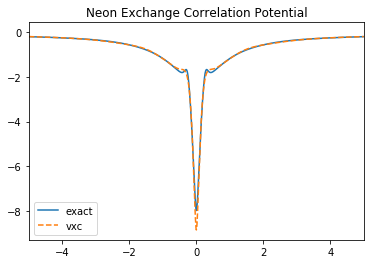

In [5]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

plt.plot(Ne_xyz, Ne_vxc, label="exact")
plt.plot(x,  vxc_ne, label="vxc", ls="--")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [6]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.5, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831864632262068
SCF Converged for lambda:   62. Max density difference: 4.331427174962073
SCF Converged for lambda:  114. Max density difference: 1.4784581181753538
SCF Converged for lambda:  166. Max density difference: 0.48364442240711014
SCF Converged for lambda:  218. Max density difference: 0.09675228413550485
SCF Converged for lambda:  270. Max density difference: 0.05905673464269512

ZMP halted. Density Error Stops Updating: old: 0.05905673464269512, current: 0.12012445290463347.


(-5, 5)

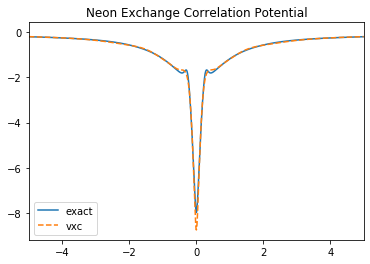

In [7]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

plt.plot(Ne_xyz, Ne_vxc, label="exact")
plt.plot(x,  vxc_ne, label="vxc", ls="--")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [8]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831864633000464
SCF Converged for lambda:   62. Max density difference: 5.340430085826824
SCF Converged for lambda:  114. Max density difference: 3.155425441929083
SCF Converged for lambda:  166. Max density difference: 2.2068364831242206
SCF Converged for lambda:  218. Max density difference: 1.6773001695470384
SCF Converged for lambda:  270. Max density difference: 1.3399424562046534
SCF Converged for lambda:  322. Max density difference: 1.1066192224224096
SCF Converged for lambda:  374. Max density difference: 0.9359217593384983
SCF Converged for lambda:  426. Max density difference: 0.8058242033411034
SCF Converged for lambda:  478. Max density difference: 0.7035307142510874
SCF Converged for lambda:  531. Max density difference: 0.6210999640877617
SCF Converged for lambda:  583. Max density difference: 0.5533432224785884
SCF Converged for lambda:  635. Max density difference: 0.49672760609678335
SCF Converge

(-5, 5)

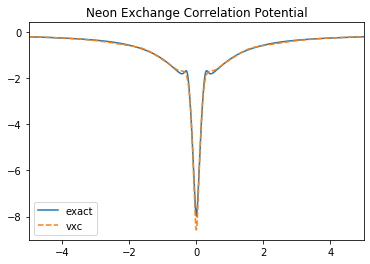

In [9]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

plt.plot(Ne_xyz, Ne_vxc, label="exact")
plt.plot(x,  vxc_ne, label="vxc", ls="--")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [10]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.1, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.83186463226798
SCF Converged for lambda:   62. Max density difference: 5.1386594145665185
SCF Converged for lambda:  114. Max density difference: 2.7821025246886393
SCF Converged for lambda:  166. Max density difference: 1.7541556394875215
SCF Converged for lambda:  218. Max density difference: 1.1873000713075044
SCF Converged for lambda:  270. Max density difference: 0.8344620098447422
SCF Converged for lambda:  322. Max density difference: 0.5980956662384642
SCF Converged for lambda:  374. Max density difference: 0.4318485836928403
SCF Converged for lambda:  426. Max density difference: 0.3108563869820955
SCF Converged for lambda:  478. Max density difference: 0.22058609362045445
SCF Converged for lambda:  531. Max density difference: 0.1519819312134132
SCF Converged for lambda:  583. Max density difference: 0.09911532996954975
SCF Converged for lambda:  635. Max density difference: 0.061343592152240944
SCF Conv

(-5, 5)

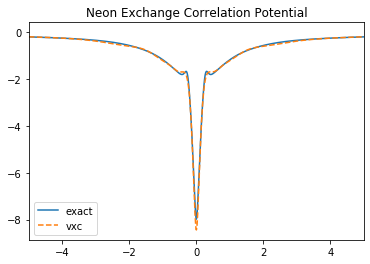

In [11]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

plt.plot(Ne_xyz, Ne_vxc, label="exact")
plt.plot(x,  vxc_ne, label="vxc", ls="--")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)